In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rpy2.robjects as ro
from functools import partial
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.ipython import html
html.html_rdataframe = partial(html.html_rdataframe, table_class = "docutils")
%load_ext rpy2.ipython

In [2]:
%%R
library(mlbench)
datasetxor <- mlbench.xor(300)
XR_datasetxor <- datasetxor$x
LABELSR_datasetxor<- datasetxor$classes

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [3]:
from rpy2.robjects import numpy2ri
numpy2ri.activate()
x_df_xor = np.array(ro.r['XR_datasetxor'])
labels_df_xor = np.array(ro.r['LABELSR_datasetxor'])
labels_df_xor[labels_df_xor == 1] = -1
labels_df_xor[labels_df_xor == 2] = 1

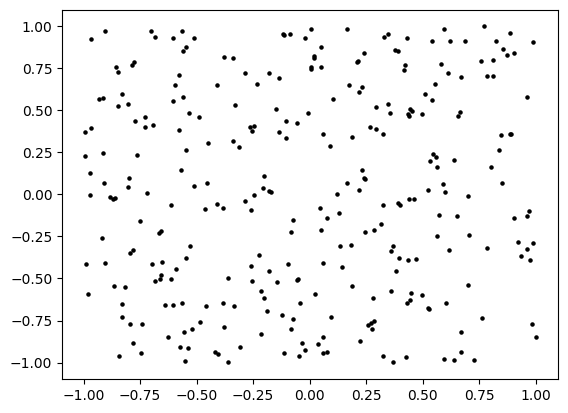

In [4]:
plt.scatter(x_df_xor[:, 0], x_df_xor[:, 1], color = 'black', s = 5)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_df_xor, labels_df_xor, random_state = 0, train_size = 0.7)

In [6]:
from sklearn.cluster import KMeans

p = 5

kmeans = KMeans(n_clusters = p, random_state = 0, n_init = 'auto').fit(X_train)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

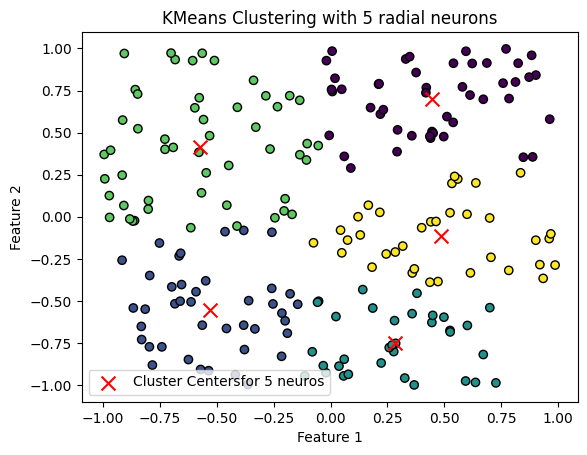

In [7]:
plt.scatter(X_train[:, 0], X_train[:, 1], c = cluster_labels, cmap = 'viridis', marker = 'o', edgecolors = 'k')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s = 100, label = f'Cluster Centersfor {p} neuros')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'KMeans Clustering with {p} radial neurons')
plt.legend()

# Show the plot
plt.show()

In [8]:
def radial_n_var(x, m, invK):
    return np.exp(-0.5* (np.dot(np.transpose(x - m), np.dot(invK, (x - m))))) # Formula PDF de n variaveis.

def trainRBF(xin : np.ndarray, yin : np.ndarray, p : int, r : float):
    try:
        N = xin.shape[0] # Number of samples
        n = xin.shape[1] # Input dimension
    except Exception as error:
        print(f"You're having the error {error}. So we will change the numer of dimensions...")
        xin = xin.reshape(-1, 1)
        n = xin.shape[1]
    
    # Realizando o cluster para encontrar os centros das funções radiais.
    x_clusters = KMeans(n_clusters = p, random_state = 0, n_init = 'auto').fit(xin)
    m = np.array(x_clusters.cluster_centers_) # Pegando os centros de cada cluster.
    
    
    covi = r*np.eye(n) # Calculando a matriz de covariancia.
    inv_covi = (1 / r)*np.eye(n) # Calculando a matriz de covariancia inversa.

    # Para cada dado de entrada : 
    # 1- Aplicar a radial_n_var do dado de entrada para cada uma das p centróides, e por fim, encontrar toda a matriz H.
    # 2- Encontrar a matriz H para cada entrada em relação a cada centróide.
    # 3- Lembrar que H[j, i] representa a distancia de cada ponto i até o centro de um cluster j.
    # 4- Lembrar que a distância aqui é a função gaussiana.
    H = np.zeros((N,p))
    for i in range(N):
        for j in range(p):
            mi = m[j,] # A variável mi conterá os centros de cada cluster.
            H[i, j] = radial_n_var(xin[i, ], mi, inv_covi)  # Calculando a distância entre cada ponto até cada centro.
        
    # Com a matriz H, a solução será obtida através da pseudoinversa.
    ones = np.ones((H.shape[0], 1))
    Haug = np.concatenate((H, ones), axis = 1)
    W = np.dot(np.linalg.pinv(Haug), yin) # Pseudoinversa sem regularização.

    return [m, covi, r, W, H]

def y_RBF(xin, modRBF):
    
    xin = np.array(xin) 
    try:
        N = xin.shape[0] # Number of samples
        n = xin.shape[1] # Input dimension
    except Exception as error:
        print(f"You're having the error {error}. So we will change the numer of dimensions...")
        xin = xin.reshape(-1, 1)
        n = xin.shape[1] 
    
    m = np.array(modRBF[0]) # Matriz que conterá todos os centros das funções radiais.
    covi = modRBF[1]# Matriz de covariâncias
    r = modRBF[2] # Raios
    inv_cov = (1 / r)*np.eye(n) # Inversa da Matriz de Covariância.
    Htr = modRBF[4] # Projeção camada intermediária conjunto de treinamento.
    p = Htr.shape[1] # Número de funções radiais (centróides ou neurônios da camada intermediária.)
    W = modRBF[3]

    H = np.zeros((N,p))
    for i in range(N):
        for j in range(p):
            mi = m[j,]
            H[i, j] = radial_n_var(xin[i, ], mi, inv_cov) # Conterá as distâncias de cada entrada a cada um dos centróides.

    ones = np.ones((H.shape[0], 1))
    Haug = np.concatenate((H, ones), axis = 1)
    Yhat = np.dot(Haug, W)# Saída da rede.
    return Yhat


In [9]:
p_cluster = 100
r_cluster = 0.6
ret_ = trainRBF(X_train, y_train, p = p_cluster, r = r_cluster)

In [19]:
ret_[0]

array([[ 3.38973563e-01,  9.44554744e-01],
       [-2.14053786e-01, -5.72760831e-01],
       [-9.14117765e-01,  5.74586587e-01],
       [ 9.19856248e-01, -2.84584556e-01],
       [ 7.45412423e-02, -1.38645169e-01],
       [ 3.25982815e-01, -9.58566797e-01],
       [-7.95118018e-01, -3.49154688e-01],
       [-1.06185191e-01,  3.37433488e-01],
       [ 3.57130036e-01,  4.81457050e-01],
       [ 8.24472113e-01,  9.12443697e-01],
       [-2.84733438e-01,  7.18947928e-01],
       [-8.00725911e-01,  9.62544382e-02],
       [-7.83492288e-01, -8.81356878e-01],
       [ 4.49030609e-01, -5.86141579e-01],
       [-3.81687630e-01, -8.11744086e-02],
       [ 6.38513168e-01,  2.01035147e-01],
       [-7.01426837e-01,  9.72736918e-01],
       [ 3.69023499e-02, -8.87762411e-01],
       [-5.31809167e-01,  4.81822709e-01],
       [ 4.40424114e-01, -2.98370789e-02],
       [ 5.79513652e-01,  7.72038191e-01],
       [ 1.93647300e-02,  8.23115185e-01],
       [-3.32777587e-01, -6.66533773e-01],
       [ 4.

In [10]:
# Assuming m, r, p, W, train_RBF are defined elsewhere
seqx1x2 = np.linspace(start = -1.5 , stop = 1.5, num = 300)
np_grid = seqx1x2.shape[0]
shape = (np_grid, np_grid)
MZ = np.zeros(shape)

# Criando o grid de valores (n x n)
for i in range(np_grid):
    for j in range(np_grid):
        x1 = seqx1x2[i]
        x2 = seqx1x2[j]
        x1x2 = np.column_stack((x1, x2))
        N = x1x2.shape[0]  # Number of samples
        n = x1x2.shape[1]  # Input dimension

        yhat = y_RBF(x1x2, ret_)
        MZ[i, j] = yhat[0]
print("Completed")

Completed


In [11]:
labels_df_xor = labels_df_xor.reshape(-1, 1)
mat_plot = np.concatenate((x_df_xor, labels_df_xor), axis = 1)
index_sort = 2
sorted_indices = np.argsort(mat_plot[:, index_sort])
mat_plot = mat_plot[sorted_indices]
x1_points = mat_plot[: 150, 0 : 2]
x2_points = mat_plot[150 :, 0 : 2]

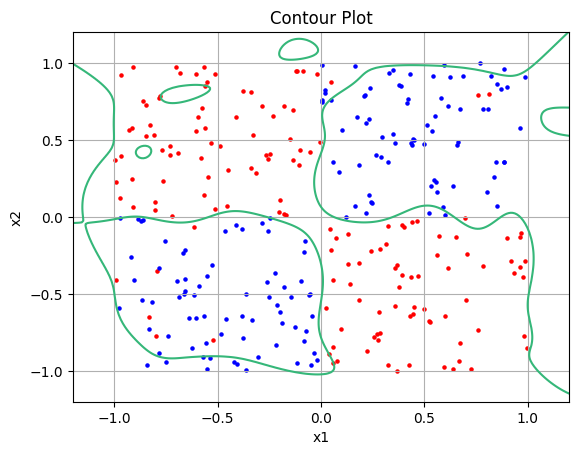

In [12]:
plt.contour(seqx1x2, seqx1x2, MZ,  levels = 1)
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data1', s = 5)
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data2', s = 5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.grid(True)
plt.show()

In [13]:
from sklearn.metrics import accuracy_score
lst_acc_test = list()
lst_param = list()
lst_ret_ = list()
r_cluster = 0.6

for i in range(1, 200, 1):
    kmeans = KMeans(n_clusters = i, random_state = 0, n_init = 'auto').fit(X_train)
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    ret_ = trainRBF(X_train, y_train, i, r = r_cluster)


    yhat_test = y_RBF(X_test, ret_)
    yhat_test[yhat_test <= -0.5] = -1
    yhat_test[yhat_test > -0.5] = 1
    lst_acc_test.append(accuracy_score(y_test, yhat_test))
    lst_param.append(i)
    lst_ret_.append(ret_)
lst_acc_test = np.array(lst_acc_test)
lst_param = np.array(lst_param)

In [14]:
idx = np.argmax(lst_acc_test)
best_p_val = lst_param[idx]
best_ret_val = lst_ret_[idx]
print(f"Using {best_p_val} neurons we have the best accuracy, that is {lst_acc_test[idx]}")

Using 72 neurons we have the best accuracy, that is 0.9222222222222223


In [15]:
# Assuming m, r, p, W, train_RBF are defined elsewhere
seqx1x2 = np.linspace(start = -1.5 , stop = 1.5, num = 300)
np_grid = seqx1x2.shape[0]
shape = (np_grid, np_grid)
MZ = np.zeros(shape)

# Criando o grid de valores (n x n)
for i in range(np_grid):
    for j in range(np_grid):
        x1 = seqx1x2[i]
        x2 = seqx1x2[j]
        x1x2 = np.column_stack((x1, x2))
        N = x1x2.shape[0]  # Number of samples
        n = x1x2.shape[1]  # Input dimension

        yhat = y_RBF(x1x2, best_ret_val)
        MZ[i, j] = yhat[0]
print("Completed")

Completed


In [16]:
labels_df_xor = labels_df_xor.reshape(-1, 1)
mat_plot = np.concatenate((x_df_xor, labels_df_xor), axis = 1)
index_sort = 2
sorted_indices = np.argsort(mat_plot[:, index_sort])
mat_plot = mat_plot[sorted_indices]
x1_points = mat_plot[: 150, 0 : 2]
x2_points = mat_plot[150 :, 0 : 2]

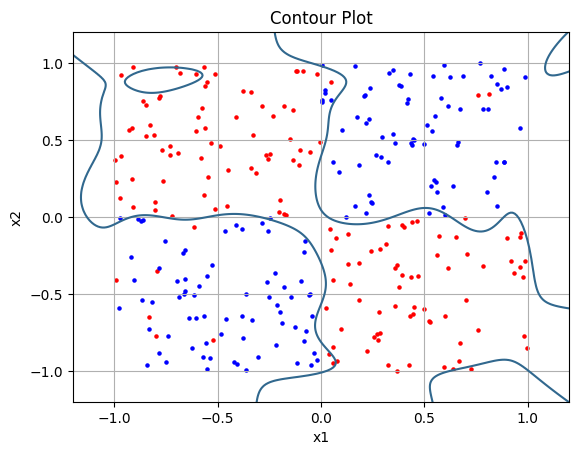

In [17]:
plt.contour(seqx1x2, seqx1x2, MZ,  levels = 1)
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data1', s = 5)
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data2', s = 5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.grid(True)
plt.show()